In [3]:
# Numerical Data Manipulation libraries
import pandas as pd
import numpy as np
import statistics as stat

# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from wordcloud import WordCloud
sns.set()


# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle

# Text Analysis libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

#natural Language Proccessing libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nebojsa77/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Question 

**How can hateful text be policed more effectively?** 

Due to polarising figures like Donald Trump having more influence on social media, especially on twitter in this case, hate and hatefilled comments seem more and more commonplace in society. Furthermore many have put the blame onto social media companies like Facebook and Twitter. Getting ontop of this should be a priority of companies. Analysing text to determine its sentiment should be the right first step.

## Data

In [4]:
train = pd.read_csv('data/train_tweet.csv')
test = pd.read_csv('data/test_tweets.csv')

This dataset was chosen as it has test and train data so that I can test and train my sentiment analysis dataset as well as perform any other text analysis techniques I deem necessary.

### Anlaysis, Visualisation & Processing

Getting a look at the shape and layout of my dataset

In [5]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [6]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


It is noted that;
label 0 = **Positive** sentiment
label 1 = **Negative** sentiment

In [7]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


Checking for null values in my datasets.

In [8]:
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
test.isnull().sum()

id       0
tweet    0
dtype: int64

I need to have a look at the spread of labels in the train dataset to see

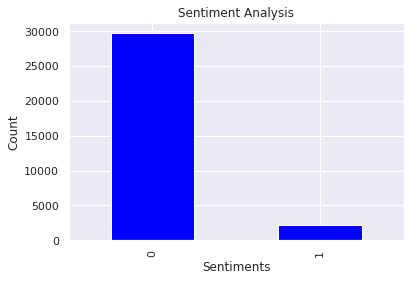

In [10]:
train['label'].value_counts().plot.bar(color = 'blue', figsize = (6, 4))
plt.title('Sentiment Analysis')
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.show()

It is clear that the vast majority of the dataset are positive tweets. This would allign with the reality of browsing Twitter.

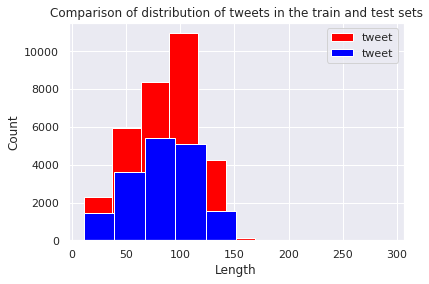

In [45]:
#checking to see of there is a significant difference between tweet lengths between my datasets
length_train = train['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

plt.title('Comparison of distribution of tweets in the train and test sets')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

It doesnt look like there is any significant diffenrence in tweet length between my datasets. However, due to the lack of tweets over 140 characters it seems as this data has been taken before Twitter changed the max character cap to 280. I will now add a length column that represents the length of tweets just incase there seems to be a relationship here.

In [12]:
train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

In [13]:
train.head() #making sure it worked

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 20')

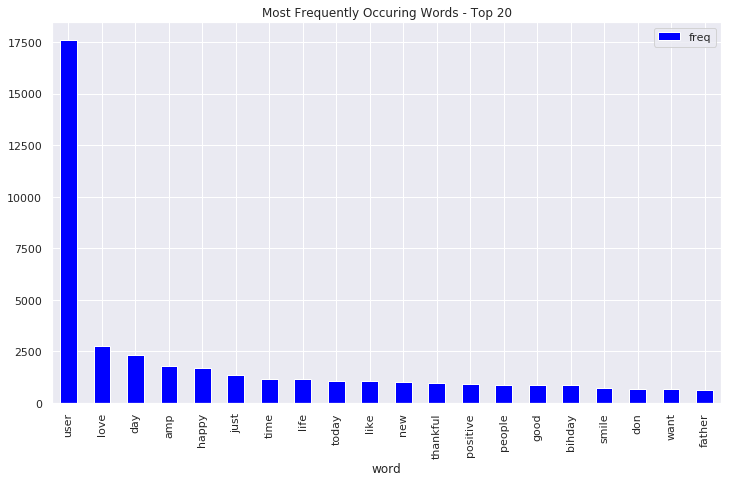

In [14]:
# making an object for the count vectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(12, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 20")

I will create some word clouds to help me get a better understanding of the words used

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

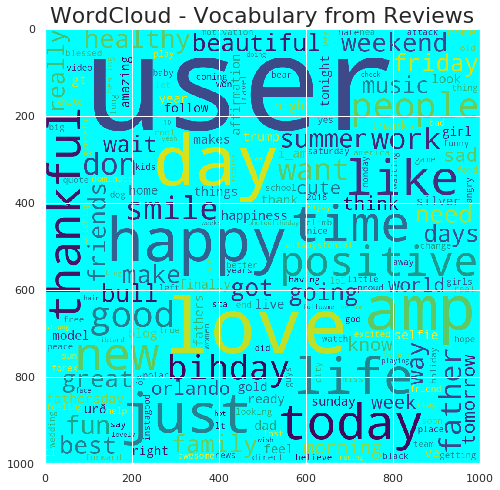

In [15]:
#some general word frequencies
wordcloud = WordCloud(background_color = 'cyan', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

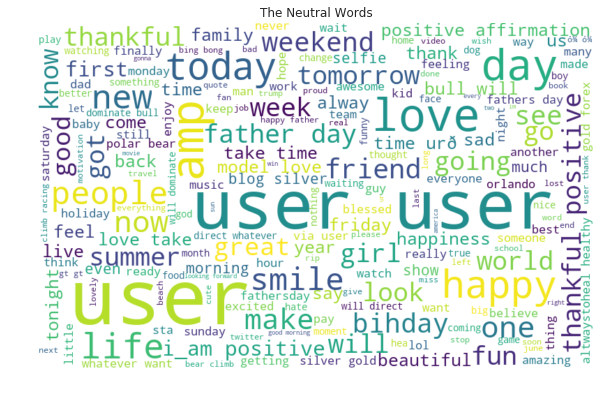

In [16]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])
#neutral sentiments

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

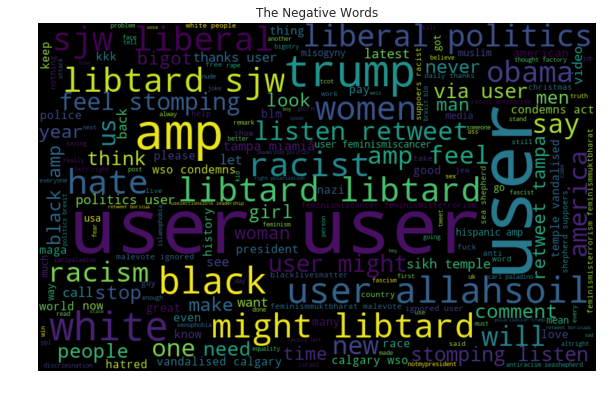

In [17]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

The Negative words seem to be targetted at users, politics and religious beliefs. While the neutral tweets seem more personal in nature with words like love, fathers, happiness and i_am involved.

I need to clean the data some more. Extracting the hastags will allow me to see what topics people are talking about during positive and negative tweets. This will allow Twitter to know which topics need to be looked at more closely.

In [18]:
#extracting the hastags
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [19]:
# extracting hashtags from positive sentiment tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from negative sentiment tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

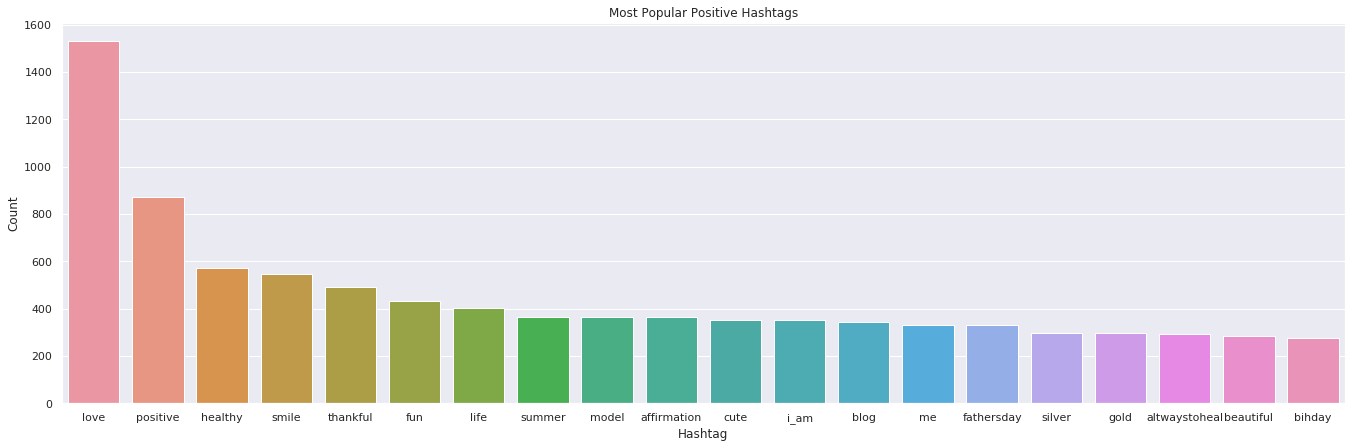

In [20]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent positive hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(23,7))
plt.title('Most Popular Positive Hashtags')
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

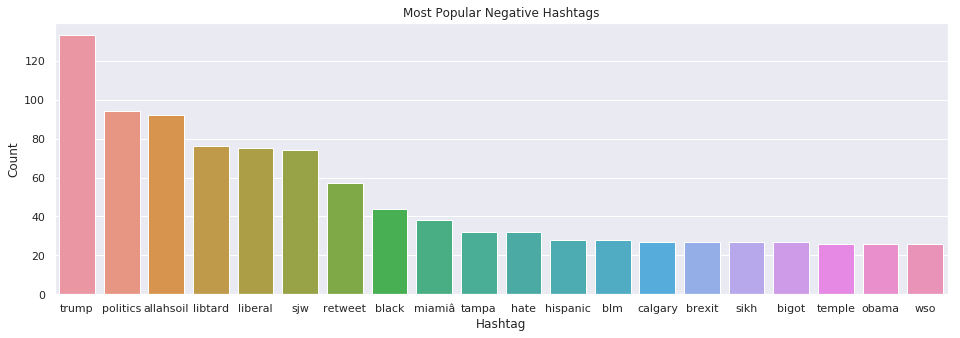

In [21]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent negative hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
plt.title('Most Popular Negative Hashtags')
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

There seems to be a clear difference in topic for positive and negative hashtags. Most of the negative hastags focus on political or religious topics. This alligns with observations made in the wordclouds. Users posting with these hashtags could potentially be targeted with advertisements or twitter campaigns that promote having an open dialogue with people whom we disagree with to help quell the hate Twitter is often known to contain on its website. This would obviously have a big impact on the Twitter user experience. Targeting specific people would obviously have an impact on them with the content they see, however, this may alos have an impact on the ontent they post. Thus, making the twitter browsing experience a more positive one for all people involved.

Creating a model that can classify tweets would prove beneficial, so thats what I will do next.

In [22]:
# tokenizing the words present in the training set
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

In [23]:
#loading a previously saved MLA
filename = "word_vec.sav"
loaded_vec = pickle.load(open(filename, "rb"))

In [24]:
# testing the model
# finding similar words to money

loaded_vec.wv.most_similar(positive = "money")

[('money.', 0.5970350503921509),
 ('coworker', 0.5799846649169922),
 ('#airingofthegrievances', 0.5669327974319458),
 ('"black', 0.5552725791931152),
 ('aap', 0.5486186742782593),
 ('replies', 0.5426814556121826),
 ('threatening', 0.5424720644950867),
 ('taxpayers', 0.5411040782928467),
 ('tax', 0.5404148101806641),
 ('required', 0.5394432544708252)]

In [38]:
# finding similar words to apple

loaded_vec.wv.most_similar(positive = "apple")

[('"mytraining"', 0.7630884647369385),
 ('mytraining', 0.7608764171600342),
 ('training"', 0.7431501746177673),
 ('app,', 0.6966886520385742),
 ('app', 0.680078387260437),
 ('"my', 0.6651307940483093),
 ('ta', 0.6535255908966064),
 ('#expressjs', 0.6260688304901123),
 ('heroku', 0.622100830078125),
 ("domino's", 0.6219728589057922)]

In [26]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


[LabeledSentence(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 LabeledSentence(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandn

In [27]:
# making a copus of cleaned and processed words with their counts
# for the training data set

train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)
    
#This takes a while

In [28]:
# making a copus of cleaned and processed words with their counts
# for the test data set

test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

#takes a while

In [29]:
cv = CountVectorizer(max_features = 100) #cant do more than 100 due to memory
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

(31962, 100)
(31962,)


In [30]:
cv = CountVectorizer(max_features = 100) #100 is the max due to memory error
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

#takes time

(17197, 100)


Due to the memory constraints the effectiveness of my models may be limited to some degree.

In [31]:
# splitting the training data into train and valid sets

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.3, random_state = 42)



In [32]:
from sklearn.preprocessing import StandardScaler
#Standardising the dataset

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Accuracy : 0.9474813391141108
Validation Accuracy : 0.9276254041088747
F1 score : 0.2041284403669725
[[8806   99]
 [ 595   89]]


The model has an accuracy of 92% Twitter can use this model to help classify tweets, this will help them monitor tweets making them more able to protect themselves from lawsuits, saying that they are doing something about the hate speech on their website. They could look at some form of censorship, or blocking people from seeing hate tweets targetted at them.

In [34]:
from sklearn.metrics import classification_report

cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      8905
           1       0.47      0.13      0.20       684

   micro avg       0.93      0.93      0.93      9589
   macro avg       0.71      0.56      0.58      9589
weighted avg       0.90      0.93      0.91      9589



In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

# making a classification report

from sklearn.metrics import classification_report

cr = classification_report(y_valid, y_pred)
print(cr)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Accuracy : 0.9316139990166719
Validation Accuracy : 0.9291896965272708
f1 score : 0.10540184453227931
[[8870   35]
 [ 644   40]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8905
           1       0.53      0.06      0.11       684

   micro avg       0.93      0.93      0.93      9589
   macro avg       0.73      0.53      0.53      9589
weighted avg       0.90      0.93      0.90      9589



In [36]:
from sklearn.metrics import classification_report

cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8905
           1       0.53      0.06      0.11       684

   micro avg       0.93      0.93      0.93      9589
   macro avg       0.73      0.53      0.53      9589
weighted avg       0.90      0.93      0.90      9589



Due to the accuracy here, this model would misclassify 10% of tweets. This may not seem like alot, but with the potential of censoring people, and the sheer number of tweets tweeted everyday there could be serious repurcusions for twitter here. If people feel they are being unfairly censored they may boycot the site. Furthermore, as many of the topics are either religion or politics they could feel their opinions and core beliefs are being unjustly censored. This could lead to mass boycots of the site. All this to be considered along with the fact that only 53% of hateful tweets (the actual target of this alogrithm) would be correctly identified. Twitter must consider how impactful negative tweets are to their website. Then they must decide how much collateral they would be willing to accept.

### Insight

Twitter can utilise the models I made to help with limiting the effects of hate speech on their platform. Furthermore, due to the immense amount of text data on their website they can utilize the hashtag data and graphs to focus their efforts on. However, due to the memory capacity, the model really struggles to identify hate speech as effectively as would be prefered, as a result shouldn't be used, or at least should be re trained on a system with more memory to allow for more accurate predictions due to the possible negative impacts of misclassifying tweets.